### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys

#add path
sys.path.insert(0, '../../src/simulator')     # import path/to/synthpy

import config
#config.jax_init()

import beam as beam_initialiser
import domain as d
import propagator_int_test as p
import diagnostics as diag
#import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(d)
importlib.reload(p)
importlib.reload(diag)
#importlib.reload(utils)

<module 'diagnostics' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/examples/notebooks/../../src/simulator/diagnostics.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [3]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

#n_cells = np.array([128, 100, 50])
n_cells = 128

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

#domain = d.ScalarDomain(x = x, y = y, z = z, extent = probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells, ne_type = "test_exponential_cos")#, leeway_factor = 250)#, probing_direction = probing_direction) # B_on = False by default
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

# only necessary to do so if you are not using the domain initialisation default distribution loading
# - that is the best option if using a test distribution

Predicted size in memory of domain: 8.0 MB

Free memory: 4.648303985595703 GB
Est. memory limit: 35.2 MB --> inc. +10% variance margin.

Coordinates have shape of (128, 128, 128) --> no padding required.

Generating test exponential decay periodic -e field...


/home/administrator/Programs/anaconda3/envs/testing/lib/python3.12/site-packages/jax/_src/numpy/scalar_types.py:50: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


In [4]:
import domain_alt as cf_d

cf_domain = cf_d.ScalarDomain(lengths, n_cells)
cf_domain.test_exponential_cos()

print(domain.x_length, domain.y_length, domain.z_length)
print(cf_domain.x_length, cf_domain.y_length, cf_domain.z_length)

print(domain.lengths)
print(cf_domain.lengths)

print(domain.x_n, domain.y_n, domain.z_n)
print(cf_domain.x_n, cf_domain.y_n, cf_domain.z_n)

print(domain.dims)
print(cf_domain.dims)

print(domain.x[0], domain.x[-1], domain.y[0], domain.y[-1], domain.z[0], domain.z[-1])
print(cf_domain.x[0], cf_domain.x[-1], cf_domain.y[0], cf_domain.y[-1], cf_domain.z[0], cf_domain.z[-1])

print(domain.B_on)
print(cf_domain.B_on)

print(domain.ne[0, 0, 0], domain.ne[-1, -1, -1])
print(cf_domain.ne[0, 0, 0], cf_domain.ne[-1, -1, -1])

0.01 0.01 0.02
0.01 0.01 0.02
[0.01 0.01 0.02]
[0.01 0.01 0.02]
128 128 128
128 128 128
[128 128 128]
[128 128 128]
-0.005 0.005 -0.005 0.005 -0.01 0.01
-0.005 0.005 -0.005 0.005 -0.01 0.01
False
False
6.324559e+21 6.324552e+26
6.324559e+21 6.324552e+26


Solve gradients, initialise beam, and solve

In [5]:
lwl = 1064e-9 #define laser wavelength

# initialise beam
Np = 300000    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

beam_definition = beam_initialiser.Beam(
    Np,
    beam_size,
    divergence,
    ne_extent,
    probing_direction = probing_direction,
    wavelength = lwl,
    beam_type = "circular"
)

# domain.dim - this causes a TracerBoolConversionError
# passing r_n all individually works though
# also passing ScalarDomain and extracting dim in p.solve(...) causes the same issue
# issue is due to unkown value when assigned to diffrax

#rf = p.solve(beam_definition.s0, domain, lwl, probing_extent, return_E = False, parallelise = True, jitted = True)

tracer = p.Propagator(domain, beam_definition, inv_brems = False, phaseshift = False)

# solve ray trace
tracer.calc_dndr()
print("Completed calc_dndr routine.")

final_rays = tracer.solve(parallelise = True, jitted = True)
#final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
print("Completed ray trace in", np.round(tracer.duration, 3), "seconds.")
print()

Completed calc_dndr routine.
jax compilation of solver took: 0.0003819465637207031
Time to ray trace: 16.97727131843567
Completed ray trace in 16.977 seconds.



Text(0, 0.5, 'e- density')

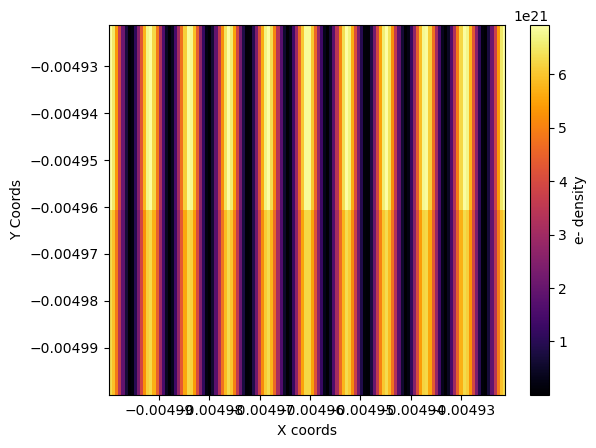

In [6]:
xy = domain.ne[:, :, -1]

heatmap, ax = plt.subplots()

im = ax.imshow([xy[0], xy[1]],cmap='inferno',extent=[domain.x[0],domain.x[1],domain.y[0],domain.y[1]],interpolation='nearest',origin='lower',aspect='auto')
ax.set(xlabel='X coords', ylabel='Y Coords')

cbar = heatmap.colorbar(im)
cbar.ax.set_ylabel('e- density')


rf size expected: (300000, 300000)
rf after clearing nan's: (300000, 300000)


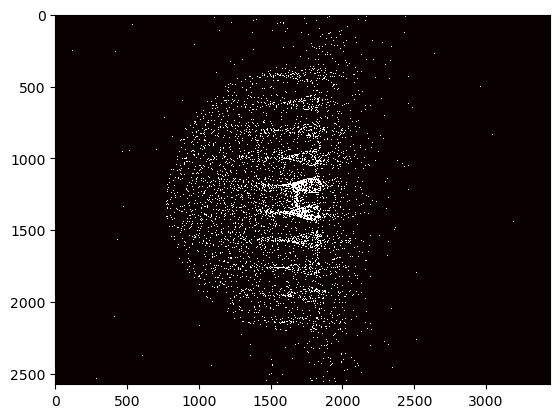

In [7]:
import jax.numpy as jnp

def m_to_mm(r):
    rr = jnp.copy(r)
    rr = rr.at[0::2, :].set(rr[0::2, :] * 1e3)

    return rr

r0 = m_to_mm(final_rays)

#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(lwl, r0)
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (300000, 300000)
rf after clearing nan's: (300000, 300000)


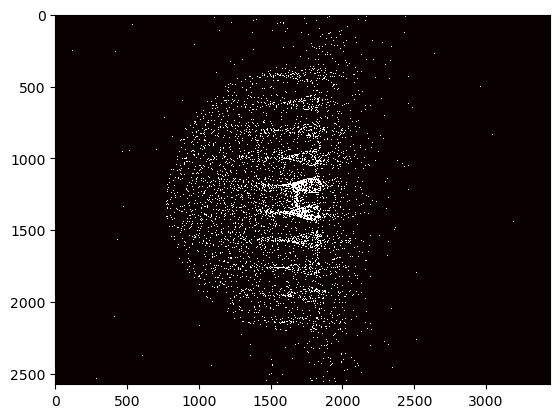

In [8]:
x = r0[0, :]
y = r0[2, :]

print("\nrf size expected: (", len(x), ", ", len(y), ")", sep='')

# means that jnp.isnan(a) returns True when a is not Nan
# ensures that x & y are the same length, if output of either is Nan then will not try to render ray in histogram
mask = ~jnp.isnan(x) & ~jnp.isnan(y)

x = x[mask]
y = y[mask]

print("rf after clearing nan's: (", len(x), ", ", len(y), ")", sep='')

bin_scale = 1
pix_x = 3448
pix_y = 2574

scaling = 1
Lx = 18 / scaling
Ly = 13.5 / scaling

H, xedges, yedges = jnp.histogram2d(x, y, bins=[pix_x // bin_scale, pix_y // bin_scale], range=[[-Lx / 2, Lx / 2],[-Ly / 2, Ly / 2]])
H = H.T

plt.imshow(H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

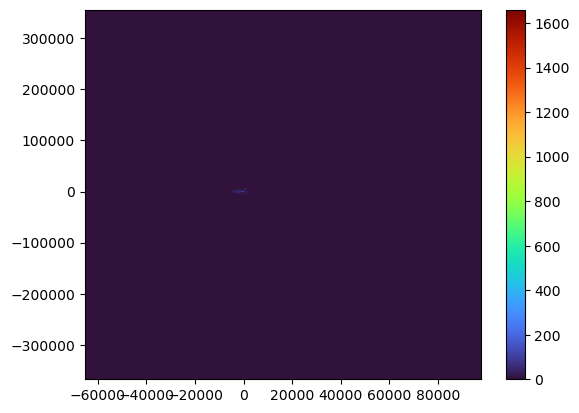

In [9]:
nbins_x=3448
nbins_y=2574

#fig, axis = plt.subplots(1, figsize = (20,5))

H,_,_,im1 = plt.hist2d(x*1e3, y*1e3, bins=(nbins_x, nbins_y), cmap="turbo")
#plt.imshow(H, cmap = 'turbo', interpolation = 'nearest', clim = (0, 10))
#im1.set_clim(0, 10)
plt.colorbar(im1)
plt.grid(False)
#axis.set_xlabel("x (mm)")
#axis.set_ylabel("z (mm)")
#axis.set_xlim([-9, 9])
#axis.set_ylim([-6.75, 6.75])

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:

In [10]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(lwl, rf, L = 50)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

NameError: name 'rf' is not defined


rf size expected: (300000, 300000)
rf after clearing nan's: (300000, 300000)


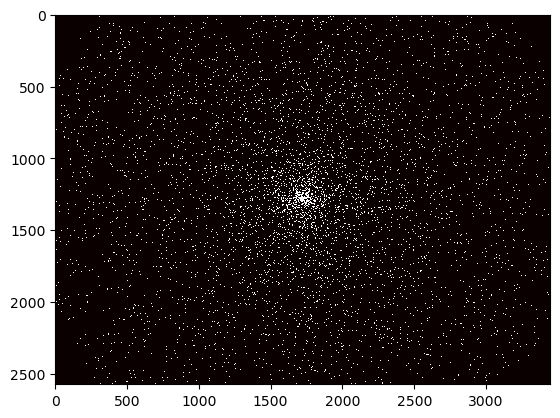

In [ ]:
shadowgrapher = diag.Shadowgraphy(lwl, rf)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (300000, 300000)
rf after clearing nan's: (0, 0)


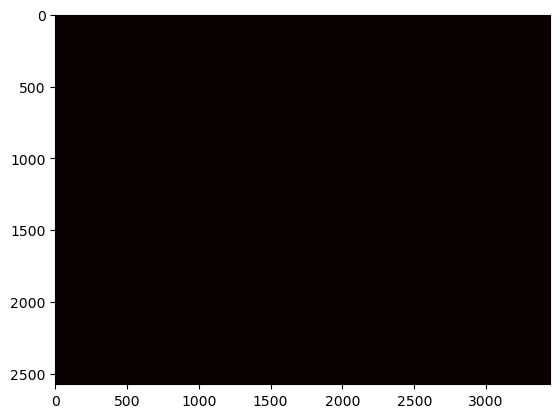

In [ ]:
schlierener = diag.Schlieren(lwl, rf)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [ ]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
tracer = p.Propagator(domain, probing_direction = probing_direction, inv_brems = False, phaseshift = True)

tracer.calc_dndr()
rf, Jf = tracer.solve(beam_definition.s0, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis

'''
interferometrer = diag.Interferometry(lwl, rf, Jf)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(lwl, rf, Jf)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')
'''

AttributeError: module 'propagator' has no attribute 'Propagator'

In [ ]:
refractometer = diag.Refractometry(lwl, rf, Jf)
refractometer.incoherent_solve()
refractometer.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

In [ ]:
refractometer = diag.Refractometry(lwl, rf, Jf)
refractometer.coherent_solve()
refractometer.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))